In [10]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, box
import matplotlib.pyplot as plt

In [5]:
df = gpd.read_file("../results/full_run/v1/first_run_all.geojson")

In [6]:
df

,polyID,confidence,layer,path,geometry
0,0,0.207167,PNOA_MA_OF_ETRS89_HU31_h50_0643,/home/biel/Desktop/test1/PNOA_MA_OF_ETRS89_HU3...,"POLYGON ((482572.256 4409404.286, 482572.256 4..."
1,1,0.226428,PNOA_MA_OF_ETRS89_HU31_h50_0643,/home/biel/Desktop/test1/PNOA_MA_OF_ETRS89_HU3...,"POLYGON ((480603.767 4409617.461, 480603.767 4..."
2,2,0.244639,PNOA_MA_OF_ETRS89_HU31_h50_0643,/home/biel/Desktop/test1/PNOA_MA_OF_ETRS89_HU3...,"POLYGON ((480932.080 4409571.753, 480932.080 4..."
3,3,0.185060,PNOA_MA_OF_ETRS89_HU31_h50_0643,/home/biel/Desktop/test1/PNOA_MA_OF_ETRS89_HU3...,"POLYGON ((481270.650 4409578.236, 481270.650 4..."
4,4,0.279460,PNOA_MA_OF_ETRS89_HU31_h50_0643,/home/biel/Desktop/test1/PNOA_MA_OF_ETRS89_HU3...,"POLYGON ((480893.242 4409654.009, 480893.242 4..."
...,...,...,...,...,...
68907,155,0.334238,PNOA_MA_OF_ETRS89_HU31_h50_0749,/home/biel/Desktop/test1/PNOA_MA_OF_ETRS89_HU3...,"POLYGON ((512750.564 4353867.770, 512750.564 4..."
68908,156,0.196058,PNOA_MA_OF_ETRS89_HU31_h50_0749,/home/biel/Desktop/test1/PNOA_MA_OF_ETRS89_HU3...,"POLYGON ((514620.417 4353881.778, 514620.417 4..."
68909,157,0.247538,PNOA_MA_OF_ETRS89_HU31_h50_0749,/home/biel/Desktop/test1/PNOA_MA_OF_ETRS89_HU3...,"POLYGON ((514688.168 4353897.801, 514688.168 4..."
68910,158,0.266268,PNOA_MA_OF_ETRS89_HU31_h50_0749,/home/biel/Desktop/test1/PNOA_MA_OF_ETRS89_HU3...,"POLYGON ((512733.645 4353919.290, 512733.645 4..."


In [7]:
truth = gpd.read_file("/media/biel/SharedHDD/Master/TFM/Cadastre/cadastre/bounding_boxes/bounding_boxes.shp")
truth.shape

(52375, 28)

In [8]:
overlaps = gpd.sjoin(df, truth)

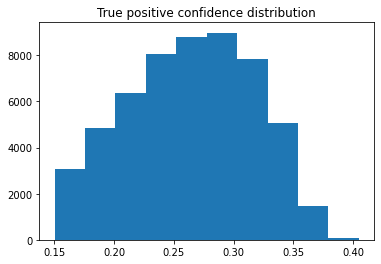

In [11]:
hard_positive = df.loc[overlaps.index]
hard_positive["confidence"].hist(grid=False)
plt.title("True positive confidence distribution");

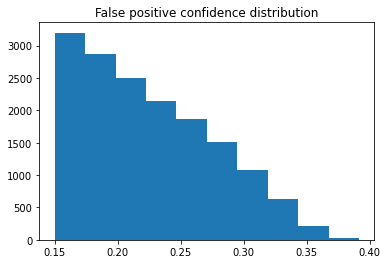

In [15]:
hard_negative = df.loc[~df.index.isin(overlaps.index)]
hard_negative["confidence"].hist(grid=False)
plt.title("False positive confidence distribution");

In [16]:
hard_positive.shape[0]

54569

In [18]:
truth.shape[0]

52375

In [17]:
hard_negative.shape[0]

16029

In [13]:
hard_positive.to_file("../results/full_run/v1/hard_positive.geojson", driver='GeoJSON')
hard_negative.to_file("../results/full_run/v1/hard_negative.geojson", driver='GeoJSON')

In [94]:
not_in = gpd.sjoin(truth, res_bbox)
misses = truth.loc[~truth.index.isin(not_in.index)]

In [96]:
misses.to_file("../results/misses.geojson", driver='GeoJSON')

## ROC curve

1. add col for true positive and false positive 

In [106]:
df["true_positive"] = np.where(df.index.isin(overlaps.index), True, False)
df["false_positive"] = np.where(~df.index.isin(overlaps.index), True, False)

In [107]:
df

,polyID,confidence,geometry,true_positive,false_positive
0,0,0.141959,"POLYGON ((504157.090 4346532.918, 504157.090 4...",False,True
1,1,0.111056,"POLYGON ((502936.377 4348615.003, 502936.377 4...",False,True
2,2,0.149852,"POLYGON ((503238.981 4349085.336, 503238.981 4...",False,True
3,3,0.334212,"POLYGON ((505096.351 4349217.633, 505096.351 4...",True,False
4,4,0.122452,"POLYGON ((503925.778 4349317.535, 503925.778 4...",False,True
...,...,...,...,...,...
733,733,0.264853,"POLYGON ((512533.137 4353341.981, 512533.137 4...",True,False
734,734,0.246031,"POLYGON ((504370.950 4353352.838, 504370.950 4...",True,False
735,735,0.149733,"POLYGON ((498799.791 4352767.206, 498799.791 4...",False,True
736,736,0.130422,"POLYGON ((500263.537 4352769.426, 500263.537 4...",False,True


In [112]:
from sklearn import metrics
import matplotlib.pyplot as plt

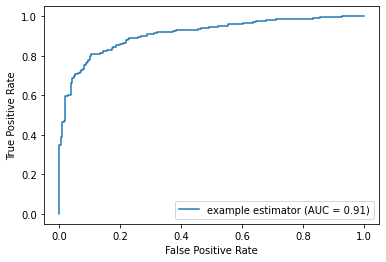

In [113]:
fpr, tpr, thresholds = metrics.roc_curve(df.true_positive, df.confidence)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()      

In [115]:
sum(df.true_positive) / truth.shape[0]

0.8981324278438031

In [116]:
sum(df.true_positive)

529

In [117]:
truth.shape[0]

589

In [118]:
sum(df.false_positive)

209